extract trajectory output  
1. depth_dic.json  
2. start.json  
3. speed_dic.json  

In [2]:
# depth 추출
import numpy as np
import os

def load_npy_files(directory):
    npy_files = [f for f in os.listdir(directory) if f.endswith('metric_depth.npy')]
    data_list = []
    for file in npy_files:
        data = np.load(os.path.join(directory, file))
        data_list.append(data)
    return data_list

directory_path = 'content/object_depths'
depth_map_list = load_npy_files(directory_path)

# depth map 길이 (=프레임 개수)
print(len(depth_map_list))

150


In [3]:
depth_map_list[0].shape

(1080, 1920)

In [4]:
depth_map_list[0].shape

(1080, 1920)

In [5]:
# 동영상 fps, shape 추출
import cv2
cap = cv2.VideoCapture('content/test.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

height, width = depth_map_list[0].shape

In [6]:
print(fps)

15.0


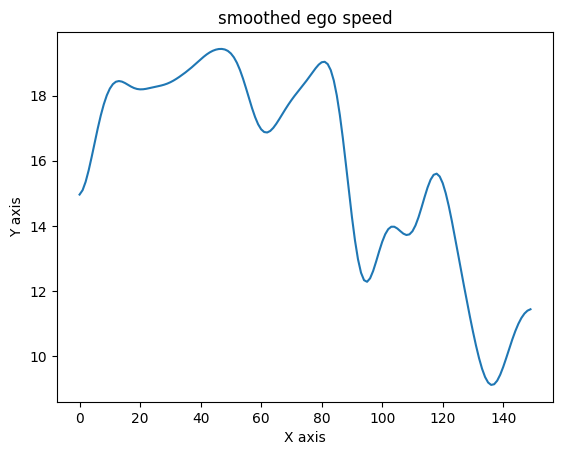

In [7]:
# ego speed 추출, smoothing
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

ego_speed_data = np.load('ego_speed.npy', allow_pickle=True)
ego_speed_data=gaussian_filter1d(ego_speed_data, sigma=5)

# 그래프 그리기
plt.plot(ego_speed_data)

plt.title("smoothed ego speed")
plt.xlabel("X axis")
plt.ylabel("Y axis")

plt.show()

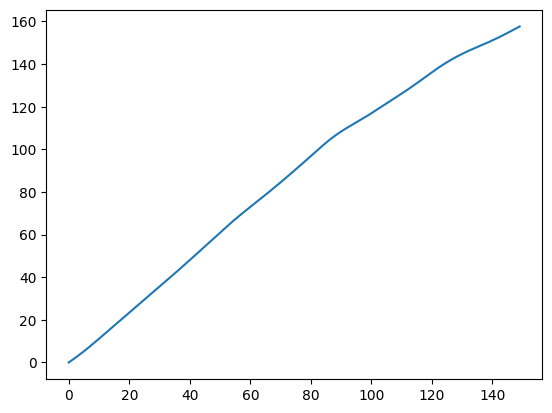

In [8]:
# ego 궤적 (z축)
ego_position = np.zeros((len(ego_speed_data)))
ego_position[1]=ego_position[0]+1

for i in range(1, len(ego_speed_data)):
    ego_position[i]=ego_position[i-1]+ego_speed_data[i]/fps

plt.plot(ego_position)

In [9]:
# tracked data 추출
tracked_data = np.load('crop_tracked_data.npy', allow_pickle=True)  ##이부분 바꿈
tracking_len = len(tracked_data)
print(tracking_len)

print(height, width)

img = cv2.imread('content/object_depths/000000_depth.png')
img_height, img_width, _ = img.shape
print(img_height, img_width)

resizing = [height/img_height, width/img_width]
print(resizing)

132
1080 1920
1080 1920
[1.0, 1.0]


In [10]:
def make_points(vehicle): ##vehicle 별로 point 추출
    result = [[] for _ in range(len(tracked_data))]
    for i, data in enumerate(tracked_data):
        if vehicle in data:
            points = data[vehicle]
            for garo in range(int(points[0]), int(points[2])):
                for sero in range(int(points[1]), int(points[3])):
                    point=garo, sero
                    result[i].append(point)
        else:
            center = None, None
            result[i].append(center)
    return result

In [11]:
def get_depth(frame, x, y) :
    if x==None or y==None :
        return None
    else :
        return depth_map_list[frame][y][x]

In [12]:
# 리스트의 중앙값을 구하는 함수 (짝수일 때 아무거나 선택)

'''
def custom_median(data):
    # 리스트 정렬
    sorted_data = sorted(data)
    n = len(sorted_data)
    
    # 리스트의 길이가 홀수일 경우 중앙값 반환
    if n % 2 == 1:
        return sorted_data[n // 2]
    # 리스트의 길이가 짝수일 경우, 중간 두 값 중 하나 선택
    else:
        # 중간에 위치한 첫 번째 값 선택
        return sorted_data[n // 2 - 1]

'''
def custom_median(data, trim_percent=10):
    # None 값을 제외하고 데이터를 오름차순으로 정렬
    sorted_data = sorted([x for x in data if x is not None])
    n = len(sorted_data)
    
    # 절단할 데이터 개수 계산
    trim_count = int(n * trim_percent / 100)
    
    # 상하위 trim_count 만큼 데이터 절단
    trimmed_data = sorted_data[trim_count : n - trim_count]
    
    # 절단된 데이터의 평균 계산
    if trimmed_data:
        return sum(trimmed_data) / len(trimmed_data)
    else:
        return None  # 절단 후 데이터가 없는 경우


In [13]:
# 동영상 내부 파라미터 입력
fx, fy, cx, cy = 1316.81, 738.72, 960, 540

def get_3dpoint(v, u, d):
    if v==None or u==None or d==None :
        return (None, None, None)
    
    Z = d
    X = (v - cx) * Z / fx
    Y = (u - cy) * Z / fy
    return [X, Y, Z]

In [14]:
# 특정 포인트의 x, y, z 구하기
def cal_x_y_z(points):
    x_list=[]
    y_list=[]
    z_list=[]
    for frame, point in enumerate(points):
        x_temp=[]
        y_temp=[]
        z_temp=[]
        for pp in point:
            u, v=pp
            d=get_depth(frame, u, v)
            x, y, z = get_3dpoint(u, v, d)
            x_temp.append(x)
            y_temp.append(y)
            z_temp.append(z)
        x_list.append(custom_median(x_temp))
        y_list.append(custom_median(y_temp))
        z_list.append(custom_median(z_temp))
    return x_list, y_list, z_list

In [15]:
# 속도 구하기 (z값만 고려)
def cal_velocity(x_list, z_list):
    vel=[] #속도 리스트
    previous_value_none=True #전 값이 None이였는지
    for i in range(len(x_list)):
        if x_list[i]==None or z_list[i]==None :
            vel.append(None)
            previous_value_none=True
        else :
            if previous_value_none :
                vel.append(None)
                previous_value_none=False
            else :
                #vel.append((((x_list[i]-x_list[i-1])*(x_list[i]-x_list[i-1])+(z_list[i]-z_list[i-1])*(z_list[i]-z_list[i-1]))**0.5)*fps)
                #vel.append((((z_list[i]-z_list[i-1])*(z_list[i]-z_list[i-1]))**0.5)*fps)
                vel.append((((z_list[i]-z_list[i-1])))*fps)
    return vel

In [16]:
import numpy as np
from scipy.ndimage import gaussian_filter1d


# NaN을 무시하고 가우시안 필터를 적용하는 함수 정의
def nan_gaussian_filter1d_separate(arr, sigma):
    nan_mask = np.isnan(arr)  # NaN 위치 마스크
    
    # NaN을 기준으로 구간을 나누고, 각 구간에 가우시안 필터 적용
    segments = []
    current_segment = []
    
    for i, val in enumerate(arr):
        if np.isnan(val):
            # 현재 구간이 비어있지 않으면, 해당 구간에 가우시안 필터 적용 후 저장
            if current_segment:
                segment_data = np.array(current_segment)
                filtered_segment = gaussian_filter1d(segment_data, sigma=sigma)
                segments.append(filtered_segment)
                current_segment = []  # 구간 초기화
            segments.append(np.nan)  # NaN은 그대로 저장
        else:
            current_segment.append(val)
    
    # 마지막 구간 처리
    if current_segment:
        segment_data = np.array(current_segment)
        filtered_segment = gaussian_filter1d(segment_data, sigma=sigma)
        segments.append(filtered_segment)
    
    # 필터링된 구간을 다시 합쳐서 원래 배열 형태로 복원
    result = []
    for segment in segments:
        if isinstance(segment, np.ndarray):
            result.extend(segment)
        else:
            result.append(segment)
    
    return np.array(result)

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression

def interpolate(array):
    y=np.array(array)
    # 유효한 (NaN이 아닌) 인덱스와 값 추출
    not_nan_indices = np.where(~np.isnan(y))[0]
    not_nan_values = y[not_nan_indices]
    
    # NaN 인덱스 추출
    nan_indices = np.where(np.isnan(y))[0]
    if len(nan_indices)==0: ## 복원 필요 없음
        return array
    
    # 학습을 위한 x 값과 y 값 생성 (index 값들을 x로 사용)
    x_train = not_nan_indices.reshape(-1, 1)  # NaN이 아닌 인덱스
    y_train = not_nan_values  # NaN이 아닌 y 값
    
    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    # NaN 위치 예측
    x_predict = nan_indices.reshape(-1, 1)
    y_predict = model.predict(x_predict)
    
    # 예측된 값으로 NaN 채우기
    y[nan_indices] = y_predict

    return y

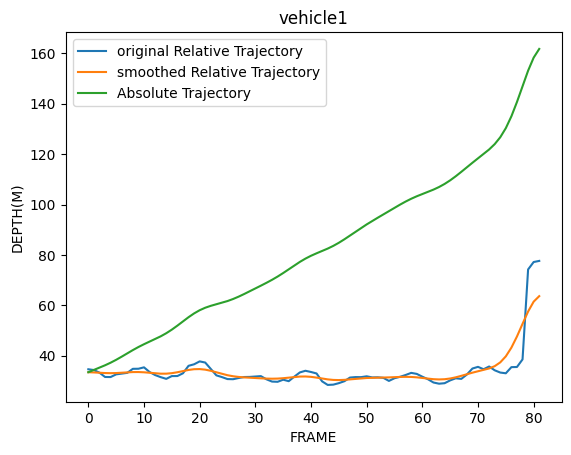

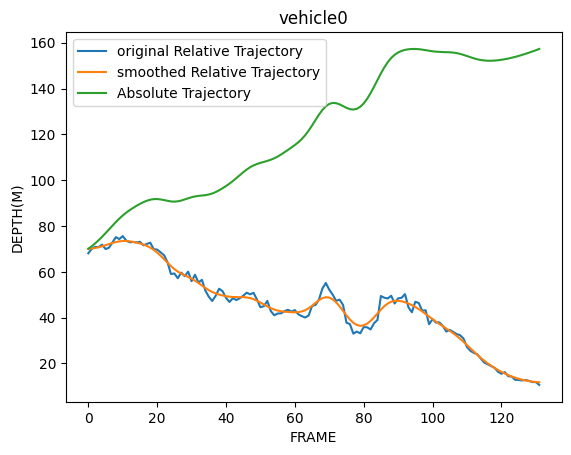

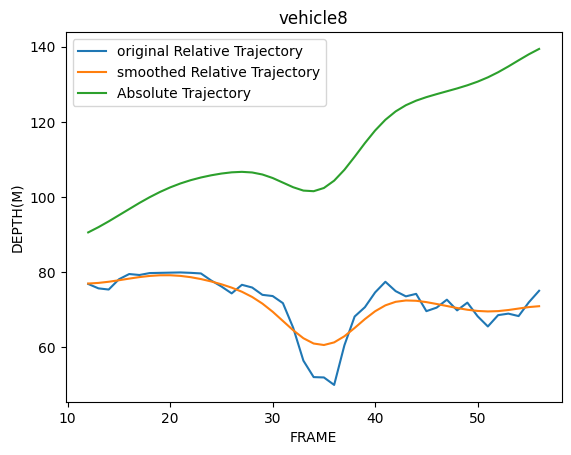

In [18]:
####### vehicle 상대 궤적, 절대 궤적(ego 차량 궤적 더한 값) plot
import json
import matplotlib.pyplot as plt

all_vehicles = set(key for data in tracked_data for key in data.keys())
depth_dic = {}
for vehicle in all_vehicles:
    points = make_points(vehicle)
    x_list, y_list, z_list=cal_x_y_z(points)
    z_list=np.array(z_list, dtype=np.float32)
    plt.plot(z_list, label="original Relative Trajectory")
    z_list = np.where(z_list == None, np.nan, z_list)
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=3)
    plt.plot(z_list, label="smoothed Relative Trajectory")

    z_list+=ego_position[:len(z_list)]
    plt.plot(z_list, label="Absolute Trajectory")
    # 그래프에 제목 및 레이블 추가
    plt.title(vehicle)
    plt.xlabel('FRAME')
    plt.ylabel('DEPTH(M)')
    # 그래프 표시
    plt.legend()
    plt.show()


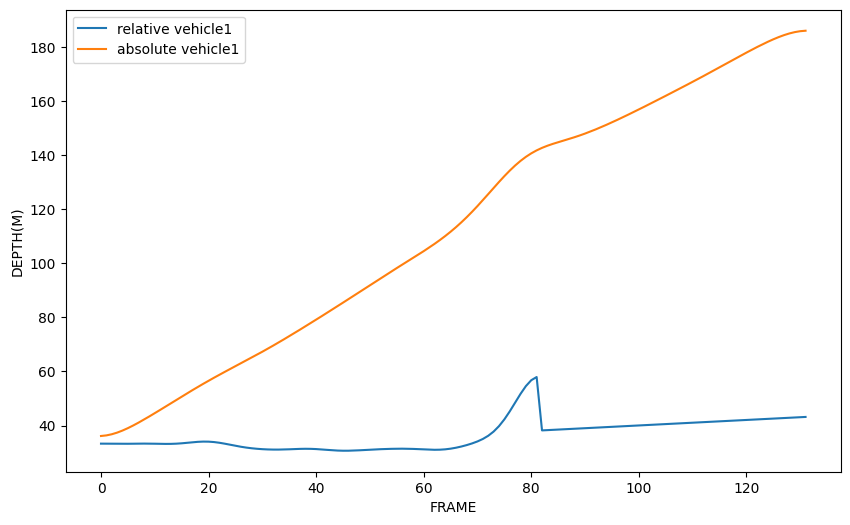

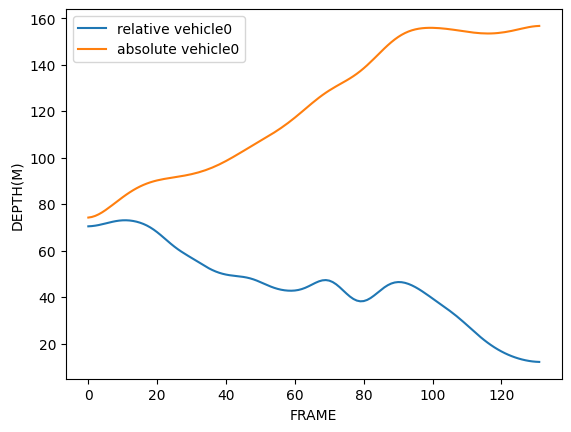

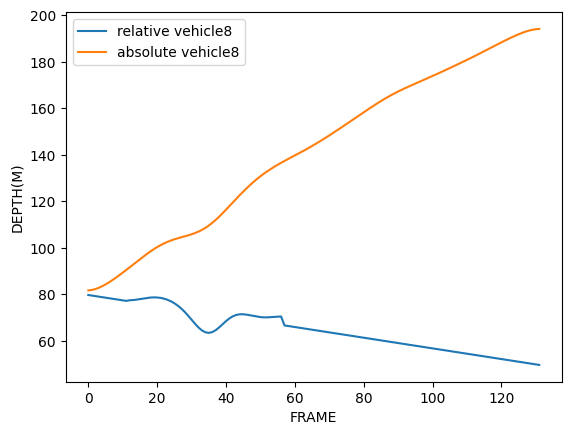

In [41]:
import json
import matplotlib.pyplot as plt
import pandas as pd

all_vehicles = set(key for data in tracked_data for key in data.keys())
velocity_dic = {}
mean_velocity_dic = {}
depth_dic = {}

# 모든 vehicle의 그래프를 하나의 figure에 그리기 위해 plt.figure() 호출
plt.figure(figsize=(10, 6))

for vehicle in all_vehicles:
    points = make_points(vehicle)
    x_list, y_list, z_list = cal_x_y_z(points)

    z_list = np.array(z_list, dtype=np.float32)
    z_list = np.where(z_list == None, np.nan, z_list)
    
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)    
    # NaN 값을 선형 보간법으로 채우기
    z_list = interpolate(z_list)
    plt.plot(z_list, label="relative "+vehicle)
    
    # Gaussian filter 적용
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)


    # ego_position 반영
    z_list+=ego_position[:len(z_list)]

    # Gaussian filter 적용
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)

    # dictionary 채우기
    depth_dic[vehicle]=z_list

    # 각 vehicle의 z_filled 값을 한 그래프에 그리기, label에 vehicle 이름 추가
    plt.plot(z_list, label="absolute "+vehicle)
    plt.xlabel('FRAME')
    plt.ylabel('DEPTH(M)')
    plt.legend()
    plt.show()

# 그래프 표시

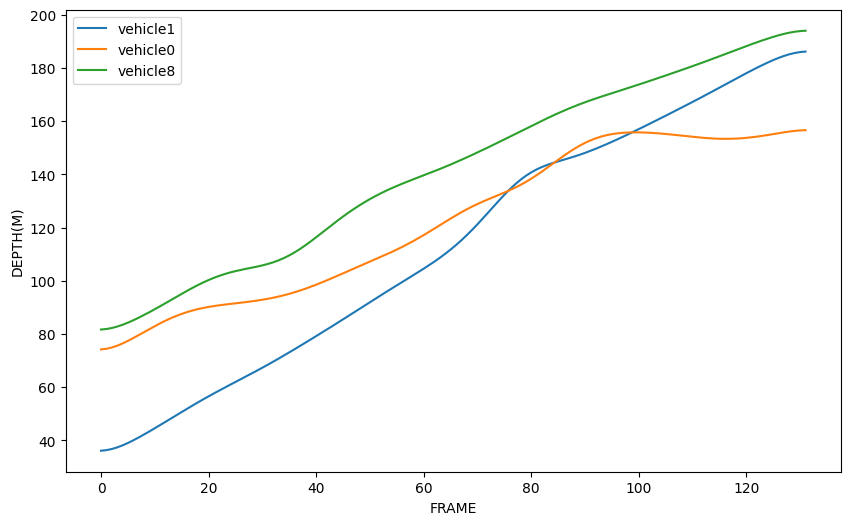

In [31]:
import json
import matplotlib.pyplot as plt
import pandas as pd

all_vehicles = set(key for data in tracked_data for key in data.keys())
velocity_dic = {}
mean_velocity_dic = {}
depth_dic = {}

# 모든 vehicle의 그래프를 하나의 figure에 그리기 위해 plt.figure() 호출
plt.figure(figsize=(10, 6))

for vehicle in all_vehicles:
    points = make_points(vehicle)
    x_list, y_list, z_list = cal_x_y_z(points)

    z_list = np.array(z_list, dtype=np.float32)
    z_list = np.where(z_list == None, np.nan, z_list)

    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)    
    # NaN 값을 선형 보간법으로 채우기
    z_list = interpolate(z_list)
    
    # Gaussian filter 적용
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)


    # ego_position 반영
    z_list+=ego_position[:len(z_list)]

    # Gaussian filter 적용
    z_list = nan_gaussian_filter1d_separate(z_list, sigma=4)

    # dictionary 채우기
    depth_dic[vehicle]=z_list

    # 각 vehicle의 z_filled 값을 한 그래프에 그리기, label에 vehicle 이름 추가
    plt.plot(z_list, label=vehicle)

plt.xlabel('FRAME')
plt.ylabel('DEPTH(M)')
plt.legend()

# 그래프 표시
plt.show()


In [21]:
depth_dic = {key: value.astype(float).tolist() for key, value in depth_dic.items()}
# JSON 파일로 저장
with open("depth_dic.json", "w") as json_file:
    json.dump(depth_dic, json_file)

In [22]:
start = {}
for vehicle, point in depth_dic.items():
    start[vehicle] = point[0]

In [23]:
import numpy as np

def depth_to_speed(depth, fps=15):
    time_interval = 1 / fps
    depth_diff = np.diff(depth)
    speed = depth_diff / time_interval
    
    return speed

speed_dic = {}

for key, depth_values in depth_dic.items():
    speed_dic[key] = depth_to_speed(depth_values, fps=15)
    # plt.plot(speed, label=key)  # 각 객체의 속도를 같은 그래프에 표시
    # plt.title(f"{key} Speed over Frames by Object")
    # plt.xlabel("Frame")
    # plt.ylabel("Speed")
    # plt.show()

In [24]:
speed_dic

{'vehicle1': array([ 3.26033877,  6.34846786,  9.12171147, 11.48793243, 13.41284929,
        14.91357062, 16.04265396, 16.86901834, 17.46136859, 17.87738327,
        18.15921524, 18.33395579, 18.41699148, 18.41638785, 18.33706243,
        18.18413358, 17.96506951, 17.69147001, 17.37922888, 17.04761567,
        16.71845626, 16.41435119, 16.15664392, 15.96340565, 15.84770992,
        15.81642933, 15.86970935, 16.00117719, 16.19884388, 16.44657191,
        16.72591769, 17.01812282, 17.30602102, 17.57564585, 17.8173641 ,
        18.02641754, 18.20282622, 18.35068386, 18.47695172, 18.58992292,
        18.69757364, 18.80603422, 18.91839737, 19.0340343 , 19.14851944,
        19.25418163, 19.34121659, 19.39922392, 19.41898047, 19.39423458,
        19.32330569, 19.21029554, 19.06576269, 18.90677269, 18.75630868,
        18.64210169, 18.59500647, 18.64709227, 18.82962746, 19.17110171,
        19.69535374, 20.41976998, 21.35342271, 22.49496616, 23.83015042,
        25.32897402, 26.94277593, 28.60

In [25]:
# speed JSON 파일로 저장
speed_dic_converted = {key: value.tolist() for key, value in speed_dic.items()}

with open("speed_dic.json", "w") as json_file:
    json.dump(speed_dic_converted, json_file)

In [26]:
with open("start.json", "w") as json_file:
    json.dump(start, json_file)